# NLP con Long-Short Term Memory (LSTM)

## Autores 

### Yasmin Johanna Garcia 
### Javier Ricardo Muñoz

### Preparación de paquetes 

In [ ]:
!pip install torch torchtext torchvision torchaudio
!pip install transformers
!pip install datasets
!pip install scikit-learn
!pip install matplotlib seaborn
!pip install --upgrade datasets huggingface_hub
!pip install imbalanced-learn]

# Cargar y explorar el dataset


# El dataset PAWS-X (Paraphrase Adversaries from Word Scrambling en su versión multilingüe) 

Corresponde a un conjunto de pares de oraciones diseñadas para evaluar la capacidad de los modelos de lenguaje en tareas de detección de paráfrasis. En particular, el subconjunto en español contiene frases que son muy similares en estructura y vocabulario, pero que no siempre tienen el mismo significado. Cada ejemplo consta de dos oraciones (sentence1 y sentence2) y una etiqueta binaria (label) que indica si ambas expresan la misma idea (1) o si, por el contrario, son diferentes (0). Este dataset es un reto interesante porque exige que el modelo capture matices semánticos sutiles y no se quede únicamente en la coincidencia superficial de palabras.

In [8]:
#Llamamos el dataset

from datasets import load_dataset
ds = load_dataset("paws-x", "es")
print(ds["train"][0])


c:\Users\yasmi\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


{'id': 1, 'sentence1': 'En París, en octubre de 1560, se reunió en secreto con el embajador inglés, Nicolas Throckmorton, pidiéndole un pasaporte para regresar a Inglaterra a través de Escocia.', 'sentence2': 'En octubre de 1560, se reunió en secreto con el embajador inglés, Nicolas Throckmorton, en París, y le pidió un pasaporte para regresar a Escocia a través de Inglaterra.', 'label': 0}


In [9]:
# Ver las columnas
print(ds["train"].features)

# Ejemplo de la primera fila
print(ds["train"][0])

{'id': Value('int32'), 'sentence1': Value('string'), 'sentence2': Value('string'), 'label': ClassLabel(names=['0', '1'])}
{'id': 1, 'sentence1': 'En París, en octubre de 1560, se reunió en secreto con el embajador inglés, Nicolas Throckmorton, pidiéndole un pasaporte para regresar a Inglaterra a través de Escocia.', 'sentence2': 'En octubre de 1560, se reunió en secreto con el embajador inglés, Nicolas Throckmorton, en París, y le pidió un pasaporte para regresar a Escocia a través de Inglaterra.', 'label': 0}


In [11]:
ds["train"].to_pandas().head(8)

,id,sentence1,sentence2,label
0,1,"En París, en octubre de 1560, se reunió en sec...","En octubre de 1560, se reunió en secreto con e...",0
1,2,La temporada de la NBA de 1975: 76 fue la 30ª ...,La temporada 1975 - 76 de la Asociación Nacion...,1
2,3,"También hay discusiones específicas, debates d...","También hay discusiones públicas, discusiones ...",0
3,4,Cuando se pueden mantener tasas de flujo compa...,Los resultados son altos cuando se pueden mant...,1
4,5,Es la sede del distrito de Zerendi en la regió...,Es la sede del distrito de Zerendi en la regió...,1
5,6,William Henry Henry Harman nació el 17 de febr...,"William Henry Harman nació en Waynesboro, Virg...",1
6,7,Bullion Express: el concepto se está introduci...,2011-Se presenta el concepto DGSE Bullion Expr...,0
7,8,Con una cantidad discreta de probabilidades Fó...,"Dado un conjunto discreto de probabilidades, l...",1


# Preprocesamiento y tokenización

In [13]:
from transformers import AutoTokenizer

# Tokenizador multilingüe (incluye español)
tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-cased")


In [14]:
def tokenize_function(examples):
    return tokenizer(
        examples["sentence1"],
        examples["sentence2"],   # usamos ambas frases
        padding="max_length",    # rellenamos hasta max_length
        truncation=True,
        max_length=64            # frases cortas → con 64 tokens basta
    )


In [16]:
tokenized_ds = ds.map(tokenize_function, batched=True)
tokenized_ds



DatasetDict({
    train: Dataset({
        features: ['id', 'sentence1', 'sentence2', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 49401
    })
    test: Dataset({
        features: ['id', 'sentence1', 'sentence2', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2000
    })
    validation: Dataset({
        features: ['id', 'sentence1', 'sentence2', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2000
    })
})

In [19]:
import torch
ejemplo = tokenized_ds["train"][0]

for k, v in ejemplo.items():
    if isinstance(v, torch.Tensor):
        print(f"{k}: shape={v.shape}, dtype={v.dtype}")
    else:
        print(f"{k}: {v if len(str(v)) < 80 else str(v)[:80] + '...'}")


id: 1
sentence1: En París, en octubre de 1560, se reunió en secreto con el embajador inglés, Nico...
sentence2: En octubre de 1560, se reunió en secreto con el embajador inglés, Nicolas Throck...
label: 0
input_ids: [101, 10243, 15850, 117, 10110, 14082, 10104, 36995, 117, 10126, 90876, 10110, 6...
token_type_ids: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...
attention_mask: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1...


In [20]:
# Calcular longitudes de los pares de oraciones concatenados
text_lengths = [len(row["sentence1"] + " " + row["sentence2"]) for row in ds["train"]]

print(f"Texto más corto: {min(text_lengths)}")
print(f"Texto más largo: {max(text_lengths)}")
print(f"Longitud promedio: {sum(text_lengths) / len(text_lengths):.2f}")


Texto más corto: 1
Texto más largo: 525
Longitud promedio: 236.36


## Preparar para Pytorch

In [21]:
import torch
from torch.utils.data import DataLoader

# Formato de tensores
tokenized_ds.set_format(type="torch", columns=["input_ids", "token_type_ids", "attention_mask", "label"])

# Crear DataLoaders
train_loader = DataLoader(tokenized_ds["train"], batch_size=32, shuffle=True)
val_loader = DataLoader(tokenized_ds["validation"], batch_size=32)
test_loader = DataLoader(tokenized_ds["test"], batch_size=32)

# Revisar un batch
batch = next(iter(train_loader))
for k,v in batch.items():
    print(k, v.shape)


label torch.Size([32])
input_ids torch.Size([32, 64])
token_type_ids torch.Size([32, 64])
attention_mask torch.Size([32, 64])


# Definir un modelo LSTM para clasificación

In [22]:
import torch
import torch.nn as nn

class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, hidden_dim=128, output_dim=2, n_layers=1, dropout=0.3):
        super(LSTMClassifier, self).__init__()
        
        # Capa de embeddings
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        
        # LSTM
        self.lstm = nn.LSTM(
            input_size=embed_dim,
            hidden_size=hidden_dim,
            num_layers=n_layers,
            batch_first=True,
            dropout=dropout if n_layers > 1 else 0
        )
        
        # Clasificación final
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, input_ids, attention_mask=None, token_type_ids=None):
        # input_ids: [batch, seq_len]
        embedded = self.embedding(input_ids)   # [batch, seq_len, embed_dim]
        lstm_out, (hidden, cell) = self.lstm(embedded)
        
        # Tomamos el último estado oculto
        hidden = hidden[-1]   # [batch, hidden_dim]
        
        # Pasamos por capa fully connected
        output = self.fc(hidden)   # [batch, output_dim]
        return output


El modelo LSTMClassifier está compuesto por tres partes principales:  

1. **Embedding Layer**: convierte los índices de palabras del vocabulario (119,547 tokens) en vectores densos de dimensión 128, permitiendo representar el significado semántico de cada palabra.  
2. **LSTM Layer**: recibe las secuencias de embeddings y captura dependencias temporales/contextuales en ambas direcciones, generando representaciones de las frases que tienen en cuenta el orden y la estructura.  
3. **Fully Connected Layer (Linear)**: toma la última representación oculta del LSTM y la proyecta a dos salidas posibles, correspondientes a las clases del problema (0 = no paráfrasis, 1 = paráfrasis).  

En conjunto, esta arquitectura permite transformar texto en predicciones de clase de manera secuencial, aprovechando la capacidad del LSTM para modelar relaciones entre palabras en oraciones.

In [23]:
vocab_size = tokenizer.vocab_size

model = LSTMClassifier(vocab_size=vocab_size, embed_dim=128, hidden_dim=128, output_dim=2)
print(model)


LSTMClassifier(
  (embedding): Embedding(119547, 128, padding_idx=0)
  (lstm): LSTM(128, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)


# Definir pérdida, optimizador y loop de entrenamiento

In [24]:
import torch
print("CUDA disponible:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("Nombre GPU:", torch.cuda.get_device_name(0))
    print("Versión CUDA en PyTorch:", torch.version.cuda)


CUDA disponible: False


In [25]:
import torch.optim as optim

# Usar GPU si está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Entrenando en:", device)

model = model.to(device)

# Función de pérdida
criterion = nn.CrossEntropyLoss()

# Optimizador
optimizer = optim.Adam(model.parameters(), lr=1e-3)


Entrenando en: cpu


## Función de entrenamiento!

In [26]:
def train_epoch(model, data_loader, criterion, optimizer, device):
    model.train()
    total_loss, total_correct = 0, 0
    
    for batch in data_loader:
        input_ids = batch["input_ids"].to(device)
        labels = batch["label"].to(device)
        
        # Forward
        outputs = model(input_ids)
        loss = criterion(outputs, labels)
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Métricas
        preds = torch.argmax(outputs, dim=1)
        total_loss += loss.item()
        total_correct += (preds == labels).sum().item()
    
    accuracy = total_correct / len(data_loader.dataset)
    return total_loss / len(data_loader), accuracy


## Función de validación 

In [27]:
def eval_epoch(model, data_loader, criterion, device):
    model.eval()
    total_loss, total_correct = 0, 0
    
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch["input_ids"].to(device)
            labels = batch["label"].to(device)
            
            outputs = model(input_ids)
            loss = criterion(outputs, labels)
            
            preds = torch.argmax(outputs, dim=1)
            total_loss += loss.item()
            total_correct += (preds == labels).sum().item()
    
    accuracy = total_correct / len(data_loader.dataset)
    return total_loss / len(data_loader), accuracy


## Loops de entrenamiento 

In [28]:
EPOCHS = 3  

for epoch in range(EPOCHS):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = eval_epoch(model, val_loader, criterion, device)
    
    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f"  Train -> Loss: {train_loss:.4f}, Acc: {train_acc:.4f}")
    print(f"  Valid -> Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")


Epoch 1/3
  Train -> Loss: 0.6871, Acc: 0.5577
  Valid -> Loss: 0.6824, Acc: 0.5780
Epoch 2/3
  Train -> Loss: 0.6844, Acc: 0.5649
  Valid -> Loss: 0.6805, Acc: 0.5820
Epoch 3/3
  Train -> Loss: 0.6734, Acc: 0.5817
  Valid -> Loss: 0.6806, Acc: 0.5800


## Evalución 

In [ ]:
import sys
!{sys.executable} -m pip install seaborn


In [30]:
import matplotlib.pyplot as plt


In [31]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluación en test set
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        labels = batch["label"].to(device)

        outputs = model(input_ids)
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Métricas generales
acc = accuracy_score(all_labels, all_preds)
print("Accuracy en test:", acc)
print("\nReporte de clasificación:\n", classification_report(all_labels, all_preds, target_names=["No paráfrasis", "Paráfrasis"]))


Accuracy en test: 0.5585

Reporte de clasificación:
                precision    recall  f1-score   support

No paráfrasis       0.56      0.97      0.71      1093
   Paráfrasis       0.62      0.07      0.12       907

     accuracy                           0.56      2000
    macro avg       0.59      0.52      0.41      2000
 weighted avg       0.59      0.56      0.44      2000



# Interpretación de resultados

## Accuracy en test: 0.5585 (~56%)
El modelo apenas supera el azar (50% en un problema binario). Eso nos dice que el LSTM no logró aprender patrones fuertes para distinguir bien entre paráfrasis y no-paráfrasis.

## Clase "No paráfrasis" (label 0)

Precision 0.56: de todas las veces que el modelo predijo no-paráfrasis, acertó un 56%.

Recall 0.97: casi todos los ejemplos de no-paráfrasis fueron detectados → el modelo tiende a predecir “no paráfrasis” casi siempre.

F1-score 0.71: balance decente porque el recall es altísimo.

## Clase "Paráfrasis" (label 1)

Precision 0.62: cuando dijo “esto sí es paráfrasis”, acertó un 62%.

Recall 0.07 😱: de todos los casos reales de paráfrasis, casi ninguno fue detectado.

F1-score 0.12: pésimo desempeño, porque el modelo prácticamente ignora esta clase.

## Promedios

Macro avg (0.41 en F1): tomando ambas clases por igual, el rendimiento es bajo.

Weighted avg (0.44 en F1): como hay más “no paráfrasis” detectados, la métrica ponderada se sostiene un poco, pero sigue siendo floja.


# Conclusión:

El modelo está desbalanceado: aprendió a reconocer muy bien la clase no paráfrasis, pero no logra identificar las paráfrasis.
En otras palabras: el LSTM se volvió flojo y dice “no paráfrasis” casi siempre, lo que le da un recall de 97% para esa clase, pero destruye el rendimiento en la otra.

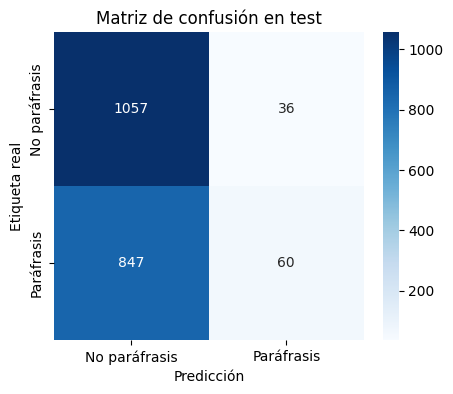

In [32]:
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["No paráfrasis", "Paráfrasis"],
            yticklabels=["No paráfrasis", "Paráfrasis"])
plt.xlabel("Predicción")
plt.ylabel("Etiqueta real")
plt.title("Matriz de confusión en test")
plt.show()


# Mejora del Modelo 

In [33]:
import numpy as np

# Contar clases en train
labels = np.array(ds["train"]["label"])
unique, counts = np.unique(labels, return_counts=True)

print("Distribución de clases:", dict(zip(unique, counts)))


Distribución de clases: {np.int64(0): np.int64(27572), np.int64(1): np.int64(21829)}


### Definir class weights

In [34]:
import torch

# Cantidades de clases
counts = torch.tensor([27572, 21829], dtype=torch.float)

# Pesos inversos a la frecuencia
class_weights = 1.0 / counts
class_weights = class_weights / class_weights.sum()  # normalizar un poco

print("Pesos de clases:", class_weights)

# Pasar a GPU si está disponible
class_weights = class_weights.to(device)

# Redefinir criterio con pesos
criterion = nn.CrossEntropyLoss(weight=class_weights)


Pesos de clases: tensor([0.4419, 0.5581])


In [35]:
## reentrenar el modelo con los nuevos pesos    
EPOCHS = 3  # puedes probar más si quieres
for epoch in range(EPOCHS):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = eval_epoch(model, val_loader, criterion, device)
    
    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f"  Train -> Loss: {train_loss:.4f}, Acc: {train_acc:.4f}")
    print(f"  Valid -> Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")


Epoch 1/3
  Train -> Loss: 0.6687, Acc: 0.5775
  Valid -> Loss: 0.6975, Acc: 0.5680
Epoch 2/3
  Train -> Loss: 0.6573, Acc: 0.5918
  Valid -> Loss: 0.6983, Acc: 0.5750
Epoch 3/3
  Train -> Loss: 0.6475, Acc: 0.6035
  Valid -> Loss: 0.7139, Acc: 0.5755


Accuracy en test: 0.536

Reporte de clasificación:
                precision    recall  f1-score   support

No paráfrasis       0.55      0.85      0.67      1093
   Paráfrasis       0.47      0.16      0.23       907

     accuracy                           0.54      2000
    macro avg       0.51      0.50      0.45      2000
 weighted avg       0.51      0.54      0.47      2000



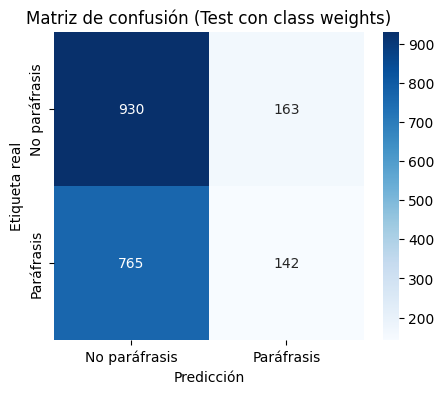

In [36]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# --- Evaluación en test ---
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        labels = batch["label"].to(device)

        outputs = model(input_ids)
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Métricas generales
acc = accuracy_score(all_labels, all_preds)
print("Accuracy en test:", acc)
print("\nReporte de clasificación:\n", classification_report(all_labels, all_preds, target_names=["No paráfrasis", "Paráfrasis"]))

# --- Matriz de confusión ---
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["No paráfrasis", "Paráfrasis"],
            yticklabels=["No paráfrasis", "Paráfrasis"])
plt.xlabel("Predicción")
plt.ylabel("Etiqueta real")
plt.title("Matriz de confusión (Test con class weights)")
plt.show()


## Interpretación de resultados

Los experimentos muestran cómo el modelo LSTMClassifier evoluciona antes y después de introducir class weights en la función de pérdida:

* En la evaluación inicial (sin pesos), el modelo obtiene un accuracy del 56%, pero está claramente sesgado hacia la clase No paráfrasis.

* Esto se ve en el recall del 97% para No paráfrasis, mientras que para Paráfrasis apenas llega a 7%.

* El modelo prácticamente ignora los casos de paráfrasis y predice casi todo como No paráfrasis.

* Tras aplicar class weights, el modelo ajusta su atención hacia la clase minoritaria.

* El accuracy global baja ligeramente (de 0.56 a 0.54), pero el recall de Paráfrasis mejora (de 0.07 a 0.16), y el F1-score sube de 0.12 a 0.23.

* Esto indica que el modelo ahora reconoce más ejemplos de paráfrasis, aunque todavía tiene dificultad para diferenciarlos bien.

* El macro promedio de F1 pasa de 0.41 a 0.45, reflejando un mejor balance entre clases.

En conclusión, aunque el accuracy global disminuye ligeramente, el modelo se vuelve más justo entre clases, dejando de estar tan sesgado hacia No paráfrasis y mostrando una mejora real en la detección de paráfrasis.

## Comparación de resultados: LSTM sin pesos vs con *class weights*

| Métrica                | Sin class weights | Con class weights |
|-------------------------|------------------:|------------------:|
| **Accuracy global**     | 0.5585            | 0.5360            |
| **Recall No paráfrasis**| 0.97              | 0.85              |
| **Recall Paráfrasis**   | 0.07              | 0.16              |
| **F1 No paráfrasis**    | 0.71              | 0.67              |
| **F1 Paráfrasis**       | 0.12              | 0.23              |
| **Macro F1**            | 0.41              | 0.45              |

### Interpretación
- El accuracy global baja un poco (0.56 → 0.54), pero esto es esperado.  
- El modelo deja de estar tan sesgado hacia *No paráfrasis*.  
- El **recall en Paráfrasis** mejora significativamente (0.07 → 0.16).  
- El **F1 en Paráfrasis** también sube (0.12 → 0.23).  
- El **macro F1** aumenta (0.41 → 0.45), lo que indica un mejor balance entre clases.

Conclusión: **el modelo gana en equidad**, reconociendo mejor la clase de *Paráfrasis*, aunque a costa de una pequeña caída en el accuracy global.
